In [98]:
from google.colab import files
uploaded = files.upload()

Saving wdbc.csv to wdbc (7).csv


In [99]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
raw_data = pd.read_csv('wdbc.csv')
raw_data.head(5)

,ID NUMBER,CLASS,rv_IF1,rv_IF2,rv_IF3,rv_IF4,rv_IF5,rv_IF6,rv_IF7,rv_IF8,rv_IF9,rv_IF10,rv_IF11,rv_IF12,rv_IF13,rv_IF14,rv_IF15,rv_IF16,rv_IF17,rv_IF18,rv_IF19,rv_IF20,rv_IF21,rv_IF22,rv_IF23,rv_IF24,rv_IF25,rv_IF26,rv_IF27,rv_IF28,rv_IF29,rv_IF30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [100]:
lb_enc = LabelEncoder()
raw_data["NEW_CLASS"] = lb_enc.fit_transform(raw_data["CLASS"])
raw_data[["CLASS", "NEW_CLASS"]]
df = raw_data.drop(['CLASS'], axis = 1)
df.tail(10)

,ID NUMBER,rv_IF1,rv_IF2,rv_IF3,rv_IF4,rv_IF5,rv_IF6,rv_IF7,rv_IF8,rv_IF9,rv_IF10,rv_IF11,rv_IF12,rv_IF13,rv_IF14,rv_IF15,rv_IF16,rv_IF17,rv_IF18,rv_IF19,rv_IF20,rv_IF21,rv_IF22,rv_IF23,rv_IF24,rv_IF25,rv_IF26,rv_IF27,rv_IF28,rv_IF29,rv_IF30,NEW_CLASS
559,925291,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,0.06570,0.2388,2.904,1.936,16.97,0.008200,0.029820,0.05738,0.01267,0.01488,0.004738,12.480,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732,0
560,925292,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,0.3645,1.492,2.888,29.84,0.007256,0.026780,0.02071,0.01626,0.02080,0.005304,15.300,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321,0
561,925311,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,0.05502,0.3141,3.896,2.041,22.81,0.007594,0.008878,0.00000,0.00000,0.01989,0.001773,11.920,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905,0
562,925622,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,0.07152,0.2602,1.205,2.362,22.65,0.004625,0.048440,0.07359,0.01608,0.02137,0.006142,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090,1
563,926125,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,0.06879,0.9622,1.026,8.758,118.80,0.006399,0.043100,0.07845,0.02624,0.02057,0.006213,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873,1
564,926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.256,7.673,158.70,0.010300,0.028910,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115,1
565,926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.463,5.203,99.04,0.005769,0.024230,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637,1
566,926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.075,3.425,48.55,0.005903,0.037310,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820,1
567,927241,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.595,5.772,86.22,0.006522,0.061580,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400,1
568,92751,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,0.05884,0.3857,1.428,2.548,19.15,0.007189,0.004660,0.00000,0.00000,0.02676,0.002783,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039,0


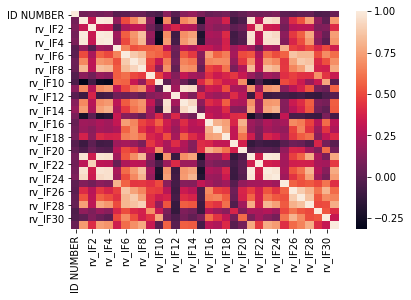

In [101]:
sns.heatmap(df.corr())

In [0]:
data_X = df.drop(['NEW_CLASS'], axis=1)
data_y = pd.DataFrame(df['NEW_CLASS'])
y = data_y.loc[:,:].values
X = data_X.iloc[:,:].values

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(455, 31)
(114, 31)
(455, 1)
(114, 1)


### Classification using RBF ANN (entire dataset)

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, RepeatVector, TimeDistributed
#setting
kval = 10
itertot = 40
sigma = 1.2
itergd = 300
def transforminput(param, center):
 newinput = np.zeros((len(param), len(center))).astype('float32')
 for i in range(len(param)):
  for j in range(len(center)):
   newinput[i,j] = np.exp(-(np.sum((param[i] - center[j])**2.0)**0.5) / sigma**2.0)
 return newinput
def generatemodel(numparam):
 model = Sequential()
 model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
# model.add(Dense(10, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model
#dividing data
trainparam = X_train
trainlabel = y_train
testparam = X_test
testlabel = y_test
###############
#normalization#
###############
std = np.zeros((len(trainparam[0]))).astype('float32')
rata = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))
for i in range(len(trainparam[0])):
 std[i] = np.std(trainparam[:,i])
 rata[i] = np.mean(trainparam[:,i])
 trainparamnorm[:,i] = (trainparam[:,i] - rata[i]) / std[i]
 testparamnorm[:,i] = (testparam[:,i] - rata[i]) / std[i]
###############
#search k-mean#
###############
#init kmean
kmean = np.zeros((kval, len(trainparamnorm[0])))
for i in range(kval):
 for j in range(len(kmean[0])):
  kmean[i,j] = random.uniform(min(trainparamnorm[:,j]),max(trainparamnorm[:,j]))
#looping of real algorithm
distmin = np.zeros((len(trainparamnorm)))
for i in range(itertot):
 print ('iterasi ke', i)
 for j in range(len(distmin)):
  #determine euclid distance
  distall = np.sum((trainparamnorm[j] - kmean)**2.0, axis=1)**0.5
  distmin[j] = np.argmin(distall)
#search new k mean
 for j in range(kval):
  clust = []
  for k in range(len(distmin)):
   if distmin[k] == j:
    clust.append(trainparamnorm[k])
  if len(clust) > 0:
   kmean[j] = np.mean(np.asarray(clust), axis=0)
#tranform our input
newinput = transforminput(trainparamnorm, kmean)
print (trainlabel)
##########################
#gradient descent session#
##########################
mod = generatemodel(kval)
mod.fit(newinput, trainlabel, batch_size=20, epochs=itergd, verbose=1, shuffle=True)
##################
#predict session#
##################
#transform test data
newinputtest = transforminput(testparamnorm, kmean)
lifeprob = mod.predict(newinputtest)
#######################
#determine performance#
#######################
#determine biner accuracy
binpred = np.zeros((len(lifeprob)))
for i in range(len(lifeprob)):
 if lifeprob[i] > 0.5:
  binpred[i] = 1.
score = 0
for i in range(len(testlabel)):
 if binpred[i] == testlabel[i]:
  score += 1
accbin = float(score) / float(len(testlabel))
#determine brier score
brierscore = 0
for i in range(len(testlabel)):
 brierscore += (testlabel[i] - lifeprob[i])**2.0
brierscore = brierscore / float(len(testlabel))
for i in range(len(testlabel)):
 print (lifeprob[i], testlabel[i])
print (accbin, brierscore[0])

iterasi ke 0
iterasi ke 1
iterasi ke 2
iterasi ke 3
iterasi ke 4
iterasi ke 5
iterasi ke 6
iterasi ke 7
iterasi ke 8
iterasi ke 9
iterasi ke 10
iterasi ke 11
iterasi ke 12
iterasi ke 13
iterasi ke 14
iterasi ke 15
iterasi ke 16
iterasi ke 17
iterasi ke 18
iterasi ke 19
iterasi ke 20
iterasi ke 21
iterasi ke 22
iterasi ke 23
iterasi ke 24
iterasi ke 25
iterasi ke 26
iterasi ke 27
iterasi ke 28
iterasi ke 29
iterasi ke 30
iterasi ke 31
iterasi ke 32
iterasi ke 33
iterasi ke 34
iterasi ke 35
iterasi ke 36
iterasi ke 37
iterasi ke 38
iterasi ke 39
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]


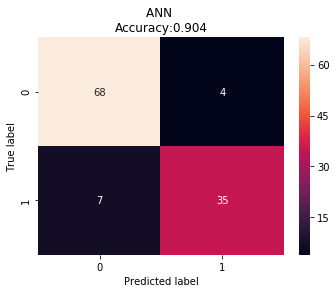

In [105]:
cm = confusion_matrix(y_test, binpred) 
plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True)
plt.title('ANN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, binpred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Dimentionality reduction using LDA

In [106]:
lda = LDA(n_components = 2)
X_lda = lda.fit_transform(X, y) 
X_lda.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(31, 2 - 1) = 1 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


(569, 1)

In [107]:
lda_data = np.vstack((X_lda.T, df['NEW_CLASS'])).T
lda_df   = pd.DataFrame(data=lda_data, columns=("1st-component","CLASS"))
lda_df.tail(5)

,1st-component,CLASS
564,4.558057,1.0
565,2.940792,1.0
566,0.984996,1.0
567,5.888918,1.0
568,-2.723290,0.0


In [108]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=0, stratify=y)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(455, 1)
(114, 1)
(455, 1)
(114, 1)




### Classification using RBF ANN (after LDA)

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, RepeatVector, TimeDistributed
#setting
kval = 10
itertot = 40
sigma = 1.2
itergd = 300
def transforminput(param, center):
 newinput = np.zeros((len(param), len(center))).astype('float32')
 for i in range(len(param)):
  for j in range(len(center)):
   newinput[i,j] = np.exp(-(np.sum((param[i] - center[j])**2.0)**0.5) / sigma**2.0)
 return newinput
def generatemodel(numparam):
 model = Sequential()
 model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
# model.add(Dense(10, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model
#dividing data
trainparam = X_train
trainlabel = y_train
testparam = X_test
testlabel = y_test
###############
#normalization#
###############
std = np.zeros((len(trainparam[0]))).astype('float32')
rata = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))
for i in range(len(trainparam[0])):
 std[i] = np.std(trainparam[:,i])
 rata[i] = np.mean(trainparam[:,i])
 trainparamnorm[:,i] = (trainparam[:,i] - rata[i]) / std[i]
 testparamnorm[:,i] = (testparam[:,i] - rata[i]) / std[i]
###############
#search k-mean#
###############
#init kmean
kmean = np.zeros((kval, len(trainparamnorm[0])))
for i in range(kval):
 for j in range(len(kmean[0])):
  kmean[i,j] = random.uniform(min(trainparamnorm[:,j]),max(trainparamnorm[:,j]))
#looping of real algorithm
distmin = np.zeros((len(trainparamnorm)))
for i in range(itertot):
 print ('iterasi ke', i)
 for j in range(len(distmin)):
  #determine euclid distance
  distall = np.sum((trainparamnorm[j] - kmean)**2.0, axis=1)**0.5
  distmin[j] = np.argmin(distall)
#search new k mean
 for j in range(kval):
  clust = []
  for k in range(len(distmin)):
   if distmin[k] == j:
    clust.append(trainparamnorm[k])
  if len(clust) > 0:
   kmean[j] = np.mean(np.asarray(clust), axis=0)
#tranform our input
newinput = transforminput(trainparamnorm, kmean)
print (trainlabel)
##########################
#gradient descent session#
##########################
mod = generatemodel(kval)
mod.fit(newinput, trainlabel, batch_size=20, epochs=itergd, verbose=1, shuffle=True)
##################
#predict session#
##################
#transform test data
newinputtest = transforminput(testparamnorm, kmean)
lifeprob = mod.predict(newinputtest)
#######################
#determine performance#
#######################
#determine biner accuracy
binpred = np.zeros((len(lifeprob)))
for i in range(len(lifeprob)):
 if lifeprob[i] > 0.5:
  binpred[i] = 1.
score = 0
for i in range(len(testlabel)):
 if binpred[i] == testlabel[i]:
  score += 1
accbin = float(score) / float(len(testlabel))
#determine brier score
brierscore = 0
for i in range(len(testlabel)):
 brierscore += (testlabel[i] - lifeprob[i])**2.0
brierscore = brierscore / float(len(testlabel))
for i in range(len(testlabel)):
 print (lifeprob[i], testlabel[i])
print (accbin, brierscore[0])

iterasi ke 0
iterasi ke 1
iterasi ke 2
iterasi ke 3
iterasi ke 4
iterasi ke 5
iterasi ke 6
iterasi ke 7
iterasi ke 8
iterasi ke 9
iterasi ke 10
iterasi ke 11
iterasi ke 12
iterasi ke 13
iterasi ke 14
iterasi ke 15
iterasi ke 16
iterasi ke 17
iterasi ke 18
iterasi ke 19
iterasi ke 20
iterasi ke 21
iterasi ke 22
iterasi ke 23
iterasi ke 24
iterasi ke 25
iterasi ke 26
iterasi ke 27
iterasi ke 28
iterasi ke 29
iterasi ke 30
iterasi ke 31
iterasi ke 32
iterasi ke 33
iterasi ke 34
iterasi ke 35
iterasi ke 36
iterasi ke 37
iterasi ke 38
iterasi ke 39
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]


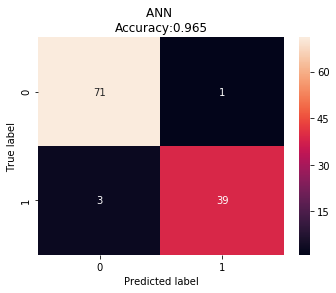

In [110]:
cm = confusion_matrix(y_test, binpred) 
plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True)
plt.title('ANN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, binpred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc
y_score = brierscore
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, binpred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), binpred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

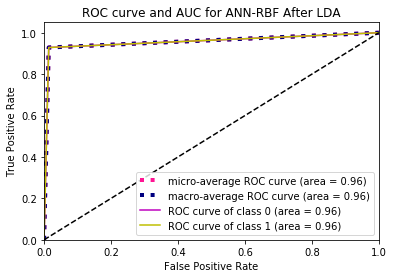

In [112]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['m', 'y', 'k'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for ANN-RBF After LDA')
plt.legend(loc="lower right")
plt.show()

#PCA


In [113]:
pca = PCA(n_components=5)
pca.fit(X,y)
pca_Data = pca.transform(X)
pca_Data.shape

(569, 5)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(pca_Data[:,:], y, test_size=0.2, random_state=0, stratify=y)
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(455, 5)
(114, 5)
(455, 1)
(114, 1)


In [119]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, RepeatVector, TimeDistributed
#setting
kval = 10
itertot = 40
sigma = 1.2
itergd = 300
def transforminput(param, center):
 newinput = np.zeros((len(param), len(center))).astype('float32')
 for i in range(len(param)):
  for j in range(len(center)):
   newinput[i,j] = np.exp(-(np.sum((param[i] - center[j])**2.0)**0.5) / sigma**2.0)
 return newinput
def generatemodel(numparam):
 model = Sequential()
 model.add(Dense(1, input_dim=numparam, activation='sigmoid'))
# model.add(Dense(10, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))
 # Compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model
#dividing data
trainparam = X_train
trainlabel = y_train
testparam = X_test
testlabel = y_test
###############
#normalization#
###############
std = np.zeros((len(trainparam[0]))).astype('float32')
rata = np.zeros((len(trainparam[0]))).astype('float32')
trainparamnorm = np.zeros(np.shape(trainparam))
testparamnorm = np.zeros(np.shape(testparam))
for i in range(len(trainparam[0])):
 std[i] = np.std(trainparam[:,i])
 rata[i] = np.mean(trainparam[:,i])
 trainparamnorm[:,i] = (trainparam[:,i] - rata[i]) / std[i]
 testparamnorm[:,i] = (testparam[:,i] - rata[i]) / std[i]
###############
#search k-mean#
###############
#init kmean
kmean = np.zeros((kval, len(trainparamnorm[0])))
for i in range(kval):
 for j in range(len(kmean[0])):
  kmean[i,j] = random.uniform(min(trainparamnorm[:,j]),max(trainparamnorm[:,j]))
#looping of real algorithm
distmin = np.zeros((len(trainparamnorm)))
for i in range(itertot):
 print ('iterasi ke', i)
 for j in range(len(distmin)):
  #determine euclid distance
  distall = np.sum((trainparamnorm[j] - kmean)**2.0, axis=1)**0.5
  distmin[j] = np.argmin(distall)
#search new k mean
 for j in range(kval):
  clust = []
  for k in range(len(distmin)):
   if distmin[k] == j:
    clust.append(trainparamnorm[k])
  if len(clust) > 0:
   kmean[j] = np.mean(np.asarray(clust), axis=0)
#tranform our input
newinput = transforminput(trainparamnorm, kmean)
print (trainlabel)
##########################
#gradient descent session#
##########################
mod = generatemodel(kval)
mod.fit(newinput, trainlabel, batch_size=20, epochs=itergd, verbose=1, shuffle=True)
##################
#predict session#
##################
#transform test data
newinputtest = transforminput(testparamnorm, kmean)
lifeprob = mod.predict(newinputtest)
#######################
#determine performance#
#######################
#determine biner accuracy
binpred1 = np.zeros((len(lifeprob)))
for i in range(len(lifeprob)):
 if lifeprob[i] > 0.5:
  binpred1[i] = 1.
score = 0
for i in range(len(testlabel)):
 if binpred1[i] == testlabel[i]:
  score += 1
accbin = float(score) / float(len(testlabel))
#determine brier score
brierscore1 = 0
for i in range(len(testlabel)):
 brierscore1 += (testlabel[i] - lifeprob[i])**2.0
brierscore1 = brierscore1 / float(len(testlabel))
for i in range(len(testlabel)):
 print (lifeprob[i], testlabel[i])
print (accbin, brierscore1[0])

iterasi ke 0
iterasi ke 1
iterasi ke 2
iterasi ke 3
iterasi ke 4
iterasi ke 5
iterasi ke 6
iterasi ke 7
iterasi ke 8
iterasi ke 9
iterasi ke 10
iterasi ke 11
iterasi ke 12
iterasi ke 13
iterasi ke 14
iterasi ke 15
iterasi ke 16
iterasi ke 17
iterasi ke 18
iterasi ke 19
iterasi ke 20
iterasi ke 21
iterasi ke 22
iterasi ke 23
iterasi ke 24
iterasi ke 25
iterasi ke 26
iterasi ke 27
iterasi ke 28
iterasi ke 29
iterasi ke 30
iterasi ke 31
iterasi ke 32
iterasi ke 33
iterasi ke 34
iterasi ke 35
iterasi ke 36
iterasi ke 37
iterasi ke 38
iterasi ke 39
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]


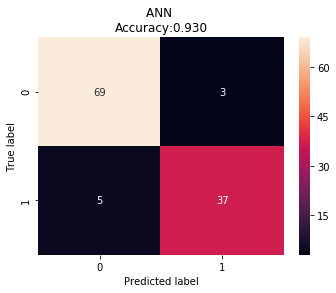

In [120]:
cm = confusion_matrix(y_test, binpred1) 
plt.figure(figsize=(5.5,4))
sns.heatmap(cm, annot=True)
plt.title('ANN \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, binpred1)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
from sklearn.metrics import roc_curve, auc
y_score = brierscore1
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, binpred1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), binpred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

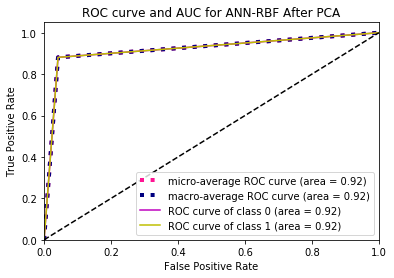

In [122]:
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['m', 'y', 'k'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve and AUC for ANN-RBF After PCA')
plt.legend(loc="lower right")
plt.show()